In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten
import pandas as pd
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import timedelta
from keras.models import load_model

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

# Pengambilan Data 

In [3]:
# Data Bank
file = 'stock_dataset/BMRI.JK.csv'
df = pd.read_csv(file, parse_dates = True,index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,5387.5,5425.0,5375.0,5412.5,4291.285645,42273400.0
2015-01-05,5425.0,5425.0,5375.0,5400.0,4281.375000,16681600.0
2015-01-06,5375.0,5412.5,5337.5,5362.5,4251.643555,29300000.0
2015-01-07,5375.0,5425.0,5362.5,5425.0,4301.195313,25122200.0
2015-01-08,5450.0,5487.5,5437.5,5475.0,4340.839355,31824800.0
...,...,...,...,...,...,...
2021-12-15,7150.0,7325.0,7125.0,7275.0,7275.000000,37838700.0
2021-12-16,7300.0,7325.0,7200.0,7250.0,7250.000000,34541200.0
2021-12-17,7225.0,7225.0,7075.0,7150.0,7150.000000,41972600.0


In [4]:
# Data Kurs Rupiah
file = 'stock_dataset/Kurs_Transaksi_USD.csv'
df1 = pd.read_csv(file, parse_dates = True,index_col=0)
df1

,Nilai,Kurs Jual,Kurs Beli
Date,,,
2015-01-02,1,12536.00,12412.00
2015-01-05,1,12652.00,12526.00
2015-01-06,1,12721.00,12595.00
2015-01-07,1,12796.00,12668.00
2015-01-08,1,12795.00,12667.00
...,...,...,...
2021-12-15,1,14419.74,14276.26
2021-12-16,1,14408.69,14265.32
2021-12-17,1,14414.72,14271.29


# Preprocessing Data

In [5]:
# menggabungkan data kurs dan data harga saham 
data = pd.merge_asof(df, df1, on='Date')
data = data.rename(columns = {'Adj Close' : 'adj_close', 'Kurs Jual' : 'kurs_jual', 'Kurs Beli' : 'kurs_beli'})
dataset = data.set_index('Date')
dataset

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2015-01-02,5387.5,5425.0,5375.0,5412.5,4291.285645,42273400.0,1,12536.00,12412.00
2015-01-05,5425.0,5425.0,5375.0,5400.0,4281.375000,16681600.0,1,12652.00,12526.00
2015-01-06,5375.0,5412.5,5337.5,5362.5,4251.643555,29300000.0,1,12721.00,12595.00
2015-01-07,5375.0,5425.0,5362.5,5425.0,4301.195313,25122200.0,1,12796.00,12668.00
2015-01-08,5450.0,5487.5,5437.5,5475.0,4340.839355,31824800.0,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...
2021-12-15,7150.0,7325.0,7125.0,7275.0,7275.000000,37838700.0,1,14419.74,14276.26
2021-12-16,7300.0,7325.0,7200.0,7250.0,7250.000000,34541200.0,1,14408.69,14265.32
2021-12-17,7225.0,7225.0,7075.0,7150.0,7150.000000,41972600.0,1,14414.72,14271.29


In [6]:
# Periksa nilai yang hilang
data.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
adj_close    1
Volume       1
Nilai        0
kurs_jual    0
kurs_beli    0
dtype: int64

In [7]:
nul_data = pd.isnull(dataset['Close']) 
dataset[nul_data]

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN,1,14342.0,14200.0


In [8]:
# Ganti nilai yang hilang dengan interpolasi
dataset = dataset.fillna(dataset.interpolate(method='linear'))
dataset.to_csv("stock_dataset/data_cleaning_bm.csv", index=True)
dataset.loc[["2019-06-19"]]

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2019-06-19,7887.5,7962.5,7850.0,7900.0,7272.0542,49423850.0,1,14342.0,14200.0


In [9]:
dataset = dataset.reset_index()
dataset

,Date,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
0,2015-01-02,5387.5,5425.0,5375.0,5412.5,4291.285645,42273400.0,1,12536.00,12412.00
1,2015-01-05,5425.0,5425.0,5375.0,5400.0,4281.375000,16681600.0,1,12652.00,12526.00
2,2015-01-06,5375.0,5412.5,5337.5,5362.5,4251.643555,29300000.0,1,12721.00,12595.00
3,2015-01-07,5375.0,5425.0,5362.5,5425.0,4301.195313,25122200.0,1,12796.00,12668.00
4,2015-01-08,5450.0,5487.5,5437.5,5475.0,4340.839355,31824800.0,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...,...
1741,2021-12-15,7150.0,7325.0,7125.0,7275.0,7275.000000,37838700.0,1,14419.74,14276.26
1742,2021-12-16,7300.0,7325.0,7200.0,7250.0,7250.000000,34541200.0,1,14408.69,14265.32
1743,2021-12-17,7225.0,7225.0,7075.0,7150.0,7150.000000,41972600.0,1,14414.72,14271.29
1744,2021-12-20,7100.0,7150.0,7075.0,7075.0,7075.000000,28966300.0,1,14414.72,14271.29


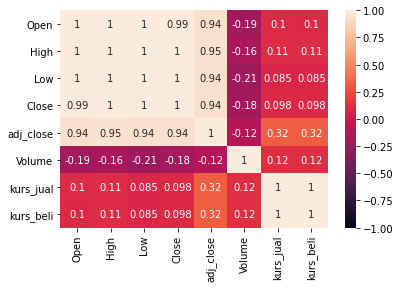

In [10]:
# Korelasi Data
dataset.drop(['Nilai'], axis=1, inplace=True)
matrix = dataset.corr(method='pearson')
ax = sns.heatmap(matrix, vmax=1, vmin=-1, annot=True)
ax.figure.savefig('M:/Metopen/save/korelasi_mr.jpg')

In [11]:
# pemilihan fitur
df = read_csv('stock_dataset/data_cleaning_bm.csv', header=0, index_col=0)
df.drop(['Volume', 'Nilai', 'kurs_jual', 'kurs_beli'], axis=1, inplace=True)
df

,Open,High,Low,Close,adj_close
Date,,,,,
2015-01-02,5387.5,5425.0,5375.0,5412.5,4291.285645
2015-01-05,5425.0,5425.0,5375.0,5400.0,4281.375000
2015-01-06,5375.0,5412.5,5337.5,5362.5,4251.643555
2015-01-07,5375.0,5425.0,5362.5,5425.0,4301.195313
2015-01-08,5450.0,5487.5,5437.5,5475.0,4340.839355
...,...,...,...,...,...
2021-12-15,7150.0,7325.0,7125.0,7275.0,7275.000000
2021-12-16,7300.0,7325.0,7200.0,7250.0,7250.000000
2021-12-17,7225.0,7225.0,7075.0,7150.0,7150.000000


In [12]:
# pindah kolom baris close ke baris pertama
last_col = df.pop('Close')
type(last_col)
pd.core.series.Series
df.insert(loc=0, column = 'Close', value = last_col)
df

,Close,Open,High,Low,adj_close
Date,,,,,
2015-01-02,5412.5,5387.5,5425.0,5375.0,4291.285645
2015-01-05,5400.0,5425.0,5425.0,5375.0,4281.375000
2015-01-06,5362.5,5375.0,5412.5,5337.5,4251.643555
2015-01-07,5425.0,5375.0,5425.0,5362.5,4301.195313
2015-01-08,5475.0,5450.0,5487.5,5437.5,4340.839355
...,...,...,...,...,...
2021-12-15,7275.0,7150.0,7325.0,7125.0,7275.000000
2021-12-16,7250.0,7300.0,7325.0,7200.0,7250.000000
2021-12-17,7150.0,7225.0,7225.0,7075.0,7150.000000


In [13]:
# pastikan semua data bertipe float
values = df.values
values = values.astype('float32')
values

# normalisasi fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.31754214, 0.3309524 , 0.30952376, 0.34782606, 0.27096653],
       [0.31519693, 0.3380952 , 0.30952376, 0.34782606, 0.2688269 ],
       [0.30816132, 0.32857144, 0.3071428 , 0.3405797 , 0.26240808],
       ...,
       [0.6435272 , 0.6809523 , 0.6523809 , 0.6763285 , 0.88814   ],
       [0.62945586, 0.6571429 , 0.6380952 , 0.6763285 , 0.87194806],
       [0.6435272 , 0.6666666 , 0.6571428 , 0.68115944, 0.88814   ]],
      dtype=float32)

In [14]:
# konversi series ke supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
# frame sebagai supervised learning
ref = series_to_supervised(scaled, 1, 1)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.317542,0.330952,0.309524,0.347826,0.270967,0.315197,0.338095,0.309524,0.347826,0.268827
2,0.315197,0.338095,0.309524,0.347826,0.268827,0.308161,0.328571,0.307143,0.340580,0.262408
3,0.308161,0.328571,0.307143,0.340580,0.262408,0.319887,0.328571,0.309524,0.345411,0.273106
4,0.319887,0.328571,0.309524,0.345411,0.273106,0.329268,0.342857,0.321429,0.359903,0.281665
5,0.329268,0.342857,0.321429,0.359903,0.281665,0.345685,0.352381,0.345238,0.367150,0.296642
...,...,...,...,...,...,...,...,...,...,...
1741,0.648218,0.661905,0.647619,0.681159,0.893537,0.666979,0.666667,0.671429,0.685990,0.915127
1742,0.666979,0.666667,0.671429,0.685990,0.915127,0.662289,0.695238,0.671429,0.700483,0.909729
1743,0.662289,0.695238,0.671429,0.700483,0.909729,0.643527,0.680952,0.652381,0.676328,0.888140
1744,0.643527,0.680952,0.652381,0.676328,0.888140,0.629456,0.657143,0.638095,0.676328,0.871948


In [16]:
# drop kolom yang tidak ingin diprediksi
ref.drop(ref.columns[[6,7,8,9]], axis=1, inplace=True)
ref.to_csv("stock_dataset/normalisasi_bm.csv", index=False)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.317542,0.330952,0.309524,0.347826,0.270967,0.315197
2,0.315197,0.338095,0.309524,0.347826,0.268827,0.308161
3,0.308161,0.328571,0.307143,0.340580,0.262408,0.319887
4,0.319887,0.328571,0.309524,0.345411,0.273106,0.329268
5,0.329268,0.342857,0.321429,0.359903,0.281665,0.345685
...,...,...,...,...,...,...
1741,0.648218,0.661905,0.647619,0.681159,0.893537,0.666979
1742,0.666979,0.666667,0.671429,0.685990,0.915127,0.662289
1743,0.662289,0.695238,0.671429,0.700483,0.909729,0.643527
1744,0.643527,0.680952,0.652381,0.676328,0.888140,0.629456


In [17]:
# pembagian data pelatihan dan pengujian
values = ref.values

train_size = 0.8
valid_size=0.1

train_index = int(len(values)*train_size)

train = values[0:train_index]
rem = values[train_index:]

valid_index = int(len(values)*valid_size)

valid = values[train_index:train_index+valid_index]
test = values[train_index+valid_index:]

print(train.shape, valid.shape, test.shape)

(1396, 6) (174, 6) (175, 6)


In [18]:
# membuat dataset
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]

# reshape masukan menjadi 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(1396, 1, 5) (1396,) (174, 1, 5) (174,) (175, 1, 5) (175,)


# Perancangan dan Pelatihan Model biLSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 178)           67640     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 178)               0         
                                                                 
 dense (Dense)               (None, 66)                11814     
                                                                 
 dropout (Dropout)           (None, 66)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 67        
                                                                 
Total params: 79,521
Trainable params: 79,521
Non-trainable params: 0
____________________________________________________

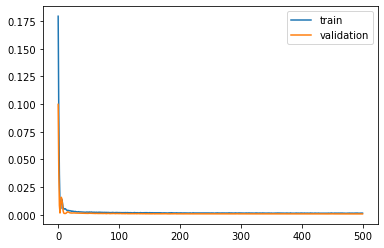

In [19]:
# membuat rancangan model
model = Sequential()
# bidirectinal layer
model.add(Bidirectional(LSTM(89, return_sequences=True),input_shape=(train_X.shape[1], train_X.shape[2])))
# fully connected layer
model.add(Flatten())
model.add(Dense(66, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='mse', optimizer= opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()
# pelatihan model
history = model.fit(train_X, train_y, batch_size= 350, epochs= 500, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.savefig('M:/Metopen/save/loss_mr.jpg', format='jpg', dpi=1000)
pyplot.legend()
pyplot.show()

In [20]:
history.history

{'loss': [0.17945857346057892,
  0.09172563999891281,
  0.03669685870409012,
  0.009575809352099895,
  0.005375575739890337,
  0.011130118742585182,
  0.013722817413508892,
  0.01101892814040184,
  0.0068418909795582294,
  0.005211036652326584,
  0.005075997672975063,
  0.005493874195963144,
  0.005305866245180368,
  0.004699027165770531,
  0.004078994505107403,
  0.0039043317083269358,
  0.003988717216998339,
  0.0038463834207504988,
  0.0035590562038123608,
  0.003740072948858142,
  0.0035589225590229034,
  0.003337844740599394,
  0.0029747195076197386,
  0.0033650361001491547,
  0.0030987753998488188,
  0.003133283229544759,
  0.002910904586315155,
  0.0028655892238020897,
  0.0029982191044837236,
  0.0027802223339676857,
  0.0027229110710322857,
  0.0026602286379784346,
  0.0025569056160748005,
  0.00273464759811759,
  0.0027152092661708593,
  0.00246368907392025,
  0.0025720824487507343,
  0.002494796644896269,
  0.0024909970816224813,
  0.0024510417133569717,
  0.0024605896323919

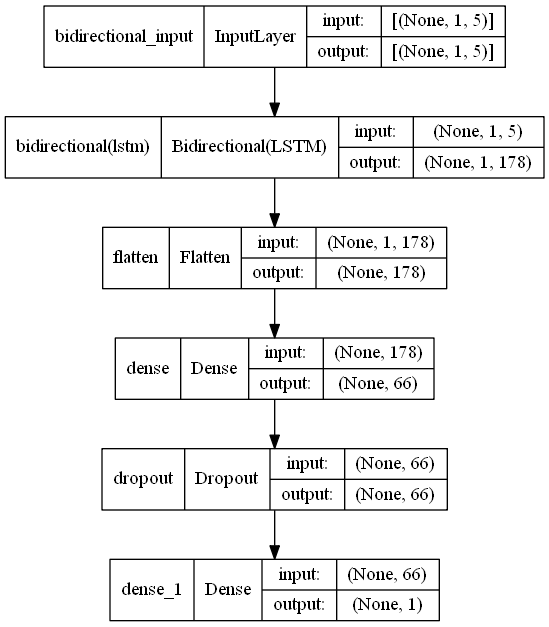

In [21]:
# plot model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='M:/Metopen/save/model_mandiri.png', show_shapes=True, show_layer_names=True)

# Evaluasi Model

In [22]:
# evaluasi model dengan data pelatihan
evaluasi = model.evaluate(train_X, train_y)
print("train loss:", "train metrics:", evaluasi)

44/44 [==============================] - 0s 2ms/step - loss: 5.5620e-04 - root_mean_squared_error: 0.0236
train loss: train metrics: [0.0005562017322517931, 0.023583929985761642]


In [23]:
# evaluasi model dengan data pengujian
evaluasi = model.evaluate(test_X, test_y)
print("test loss:", "test metrics:", evaluasi)

6/6 [==============================] - 0s 2ms/step - loss: 4.0336e-04 - root_mean_squared_error: 0.0201
test loss: test metrics: [0.00040336346137337387, 0.02008390985429287]


In [24]:
model.save('M:/Metopen/save/model_mandiri.h5')
model.save_weights('M:/Metopen/save/model_weights_mandiri.h5')

# Prediksi Data

In [25]:
# load model
model = load_model('M:/Metopen/save/model_mandiri.h5')
model.load_weights('M:/Metopen/save/model_weights_mandiri.h5')


# load data bank BRI baru
df = read_csv('stock_dataset/BMRI.JK_revisi.csv', parse_dates = True, index_col=0)
dataset = df.reset_index()

In [26]:
data = dataset.set_index('Date')
last_col = data.pop('Close')
type(last_col)
pd.core.series.Series
data.insert(loc=0, column = 'Close', value = last_col)
data

,Close,Open,High,Low,Adj Close
Date,,,,,
2021-12-22,7050,7175,7200,7050,6729.182129
2021-12-23,7075,7050,7150,7050,6753.044434
2021-12-24,7050,7100,7150,6950,6729.182129
2021-12-27,7000,7050,7100,6975,6681.457520
2021-12-28,7050,7050,7050,6975,6729.182129
...,...,...,...,...,...
2022-08-24,8625,8600,8700,8550,8625.000000
2022-08-25,8575,8550,8625,8425,8575.000000
2022-08-26,8500,8625,8650,8500,8500.000000


In [27]:
# normalisasi data uji baru
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

# konversi data uji baru
ref = series_to_supervised(scaled, 1, 1)
ref.drop(ref.columns[[6,7,8,9]], axis=1, inplace=True)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.025641,0.085714,0.074074,0.071429,0.021038,0.038462
2,0.038462,0.014286,0.049383,0.071429,0.031556,0.025641
3,0.025641,0.042857,0.049383,0.014286,0.021038,0.000000
4,0.000000,0.014286,0.024691,0.028571,0.000000,0.025641
5,0.025641,0.014286,0.000000,0.028571,0.021038,0.051282
...,...,...,...,...,...,...
160,0.833333,0.842857,0.802469,0.871429,0.856736,0.833333
161,0.833333,0.900000,0.814815,0.928571,0.856736,0.807692
162,0.807692,0.871429,0.777778,0.857143,0.834696,0.769231
163,0.769231,0.914286,0.790123,0.900000,0.801635,0.794872


In [28]:
# membuat dataset 
values = ref.values
new_test_X, new_test_y = values[:, :-1], values[:, -1]
new_test_X = new_test_X.reshape((new_test_X.shape[0], 1, new_test_X.shape[1]))
print(new_test_X.shape, new_test_y.shape)

(164, 1, 5) (164,)


In [29]:
# membuat prediksi dengan data yang baru 
predict = model.predict(new_test_X)
new_test_X = new_test_X.reshape((new_test_X.shape[0], new_test_X.shape[2]))
# denormalisasi untuk data prediksi
inv_predict = concatenate((predict, new_test_X[:, 1:]), axis=1)
inv_predict = scaler.inverse_transform(inv_predict)
inv_predict = inv_predict[:, 0]
# denormalisasi untuk data aktual
new_test_y = new_test_y.reshape((len(new_test_y), 1))
inv_actual = concatenate((new_test_y, new_test_X[:, 1:]), axis=1)
inv_actual = scaler.inverse_transform(inv_actual)
inv_actual = inv_actual[:,0]

In [30]:
# hasil prediksi sebelum denormalisasi
predict

array([[0.04824971],
       [0.05028674],
       [0.02883299],
       [0.01487951],
       [0.02188041],
       [0.04622147],
       [0.03072426],
       [0.03701886],
       [0.08087962],
       [0.0211536 ],
       [0.01446714],
       [0.03501662],
       [0.03815654],
       [0.03057642],
       [0.06923488],
       [0.07201884],
       [0.08734737],
       [0.10854641],
       [0.11184957],
       [0.03462889],
       [0.07415733],
       [0.133869  ],
       [0.13480276],
       [0.11263064],
       [0.21187402],
       [0.26971903],
       [0.32240242],
       [0.274239  ],
       [0.24895287],
       [0.22883065],
       [0.24220538],
       [0.27185678],
       [0.3245483 ],
       [0.34410834],
       [0.36756372],
       [0.36955497],
       [0.3889377 ],
       [0.4328753 ],
       [0.43267438],
       [0.41615754],
       [0.4365583 ],
       [0.44883764],
       [0.44138178],
       [0.4535338 ],
       [0.37472677],
       [0.36076987],
       [0.3594203 ],
       [0.324

In [31]:
# hasil prediksi pada setiap langkah waktu
inv_test_X= scaler.inverse_transform(new_test_X)

for i in range(len(inv_test_X)):
    print("X=%s, Predicted= %s" % (inv_test_X[i], inv_predict[i]))

X=[7050.       7175.       7200.       7050.       6729.182129], Predicted= 7094.086942449212
X=[7075.       7050.       7150.       7050.       6753.044434], Predicted= 7098.059143126011
X=[7050.       7100.       7150.       6950.       6729.182129], Predicted= 7056.224339082837
X=[7000.      7050.      7100.      6975.      6681.45752], Predicted= 7029.015044122934
X=[7050.       7050.       7050.       6975.       6729.182129], Predicted= 7042.666807956994
X=[7100.       7075.       7125.       7000.       6776.906738], Predicted= 7090.131871029735
X=[7025.       7100.       7125.       7025.       6705.319824], Predicted= 7059.9123124964535
X=[7050.       7100.       7125.       7025.       6729.182129], Predicted= 7072.18677289784
X=[7175.       7075.       7200.       7050.       6848.494141], Predicted= 7157.7152613550425
X=[7025.       7150.       7175.       6925.       6705.319824], Predicted= 7041.249510832131
X=[7025.       7075.       7075.       6950.       6705.319824],

In [32]:
# menghitung nilai RMSE dan Mape pada hasil prediksi
rmse = sqrt(mean_squared_error(inv_predict, inv_actual))
print('Test RMSE: %.2f' % rmse)
mape = np.mean(np.abs((inv_actual - inv_predict)/inv_actual))*100
print(f'Test MAPE: {np.round(mape, 2)} %')

Test RMSE: 143.87
Test MAPE: 1.23 %


In [33]:
# insert nilai tanggal, aktual, prediksi
test = dataset.drop(dataset.index[0])
test.insert(1, "Prediction", inv_predict.ravel(), True)
#test.insert(1, "Difference", test["Prediction"] - test["Actual"], True)

In [34]:
# perbandingan hasil pengujian dan prediksi
test = pd.DataFrame(test, columns = ["Date", "Close", "Prediction"])
test["RMSE"] = test.apply(lambda x: mean_squared_error(test.loc[:x.name, 'Close'].tolist(), test.loc[:x.name, 'Prediction'].tolist(), squared=False), axis = 1)
test["MAPE"] = test.apply(lambda x: np.mean(np.abs((test.loc[:x.name, 'Close'].tolist() - test.loc[:x.name, 'Prediction'])/test.loc[:x.name, 'Close'].tolist()))*100, axis=1)
test.to_csv("M:/Metopen/save/hasil_prediksi_bm.csv", index=False)
print(test)

          Date  Close   Prediction        RMSE      MAPE
1   2021-12-23   7075  7094.086942   19.086942  0.269780
2   2021-12-24   7050  7098.059143   36.564960  0.475735
3   2021-12-27   7000  7056.224339   44.102792  0.584892
4   2021-12-28   7050  7029.015044   39.609144  0.513083
5   2021-12-29   7100  7042.666808   43.732442  0.571969
..         ...    ...          ...         ...       ...
160 2022-08-24   8625  8599.656215  145.142186  1.237577
161 2022-08-25   8575  8632.530326  144.761753  1.234057
162 2022-08-26   8500  8554.452527  144.377665  1.230394
163 2022-08-29   8550  8541.712543  143.935572  1.223440
164 2022-08-30   8650  8517.563400  143.868241  1.225316

[164 rows x 5 columns]


# Visualisasi Data

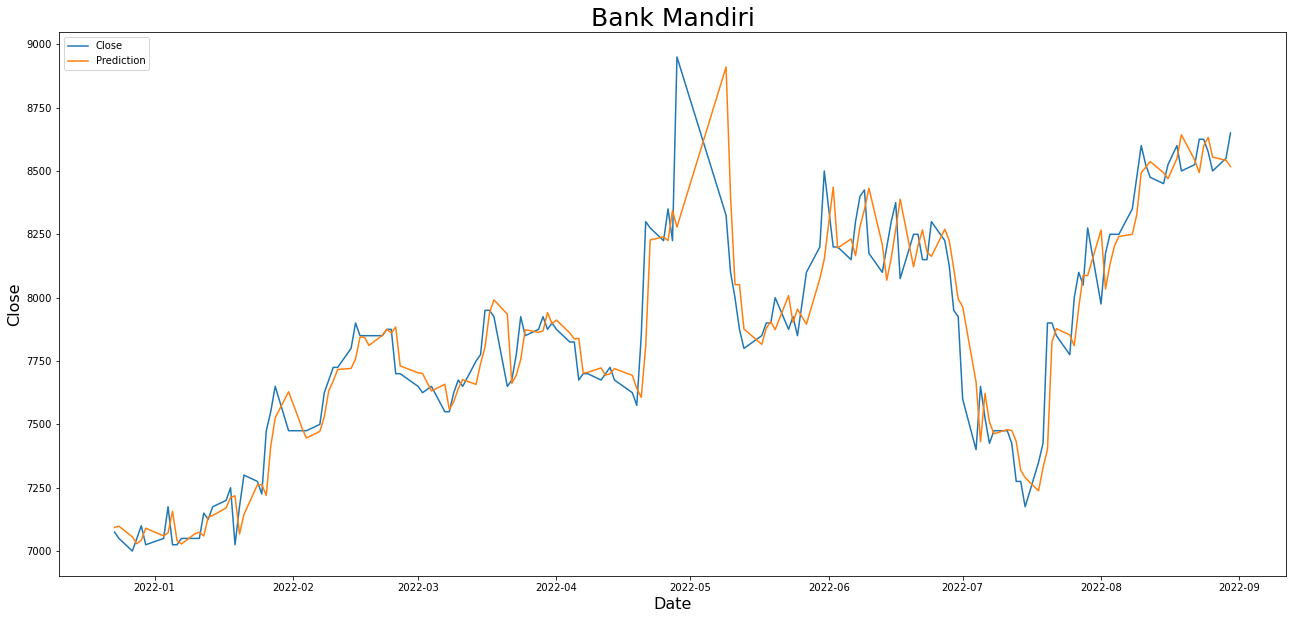

In [35]:
# visualisasi data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = test["Date"]
yt = test[["Close", "Prediction"]]
plt.title("Bank Mandiri", fontsize= 25)
plt.plot(xt, yt["Close"])
plt.ylabel("Close", fontsize= 16)
plt.xlabel("Date", fontsize= 16)
plt.plot(xt, yt["Prediction"])
plt.legend(["Close","Prediction"], loc="upper left")
plt.savefig('M:/Metopen/save/hasil_prediksi_bm.jpg', format='jpg', dpi=1000)

#plt.grid()
plt.show()